# Import Libraries

In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

import cv2
import random
import shutil
import time
import matplotlib
import glob
import operator
import psutil
import numpy as np
import math
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import *
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.regularizers import l2

from shutil import copyfile
import pandas as pd
import PIL
from mlxtend.plotting import plot_confusion_matrix
from tqdm import tqdm 

# Setting up hardware

In [2]:
physical_devices = tf.config.experimental.list_physical_devices('GPU')

if physical_devices != []:
    print("Using GPU")
    for i in physical_devices:
        tf.config.experimental.set_memory_growth(i, True)
else:
    print("Using CPU")
    pass

Using GPU


# Load Dataset

In [3]:
root_dir = str(input("Path where 'classify train' directory belongs: "))
classify_train = os.path.join(root_dir, 'classify train')

train_directory = os.path.join(classify_train, 'training')
validation_directory = os.path.join(classify_train, 'validation')
test_directory = os.path.join(classify_train, 'testing')

Path where 'classify train' directory belongs: /mnt/036b1314-13ad-429f-b9f9-07467946c5d7/Datasets/Health/OCT2017


In [4]:
train_directory, validation_directory, test_directory

('/mnt/036b1314-13ad-429f-b9f9-07467946c5d7/Datasets/Health/OCT2017/classify train/training',
 '/mnt/036b1314-13ad-429f-b9f9-07467946c5d7/Datasets/Health/OCT2017/classify train/validation',
 '/mnt/036b1314-13ad-429f-b9f9-07467946c5d7/Datasets/Health/OCT2017/classify train/testing')

# Hyper-parameter setting-1

In [5]:
learning_rate = float(input("Enter the initial learning rate: "))
epoch = int(input("Enter the maximum number of epochs: "))
batch_size = int(input("Enter batch size: "))
lambd = float(input("Enter lambda for L2 regularization: "))

Enter the initial learning rate: 0.001
Enter the maximum number of epochs: 100
Enter batch size: 8
Enter lambda for L2 regularization: 0


# Characteristics folder
Creating a seperate folder where 'classify train' belongs to store model and results

In [6]:
char_name = str(input("Enter name of the characteristics folder: "))

char = os.path.join(root_dir, char_name)

if not os.path.exists(char):
    os.mkdir(char)
else:
    replace = str(input("Folder already exists ! Do you want to replace it ?(Y/N) "))
    if replace.upper() == 'Y':      
        shutil.rmtree(char)
        os.mkdir(char)
    elif replace.upper() == 'N':
        print('\nThe following folders already exist:')
        for i in os.listdir(root_dir): 
            print(i)
        char_name = str(input("\nEnter a new name of the characteristics folder: "))
        char = os.path.join(root_dir, char_name)
        if not os.path.exists(char):
            os.mkdir(char)
        else:
            print(f"{char_name} replaced")
            shutil.rmtree(char)
            os.mkdir(char)

Enter name of the characteristics folder: Classical1


# Learning rate decay

In [7]:
steps = 10 # change steps to 1 to apply exponential decay

def lr_schedule(epoch):
    return learning_rate * (0.1 ** int(epoch / steps))
    
best_model_address = os.path.join(char, 'best_model.h5')

# Callbacks

In [8]:
monitor = int(input("Press 1 to monitor Validation Accuracy\nPress 2 to monitor Validation Loss\nPress 3 to monitor Training Accuracy\nPress 4 to monitor Training Loss\n"))
patience = int(input('Enter number of epochs that will produce monitored quantity with no improvement after which training will be stopped: '))


if monitor == 1:
    metric = 'val_accuracy'
    mode = 'max'
    print("\nMONITORING VALIDATION ACCURACY..........\n")

elif monitor == 2:
    metric = 'val_loss'
    mode = 'min'
    print("\nMONITORING VALIDATION LOSS..........\n")

elif monitor == 3:
    metric = 'accuracy'
    mode = 'max'
    print("\nMONITORING TRAINING ACCURACY..........\n")

elif monitor == 4:
    metric = 'loss'
    mode = 'min'
    print("\nMONITORING TRAINING LOSS..........\n")

callback = [keras.callbacks.LearningRateScheduler(lr_schedule, verbose = 1),
            keras.callbacks.EarlyStopping(monitor = metric, min_delta = 0.001, patience = patience, verbose=1, mode = mode, restore_best_weights = True),
            keras.callbacks.ModelCheckpoint(best_model_address, monitor = metric, verbose=1, save_best_only=True, save_weights_only=False, mode = mode)]

print(f"\nTraining will stop if {metric} doesn't show any improvements for {patience} epcohs\n")

Press 1 to monitor Validation Accuracy
Press 2 to monitor Validation Loss
Press 3 to monitor Training Accuracy
Press 4 to monitor Training Loss
4
Enter number of epochs that will produce monitored quantity with no improvement after which training will be stopped: 10

MONITORING TRAINING LOSS..........


Training will stop if loss doesn't show any improvements for 10 epcohs



# Model Architecture

In [9]:
def MobileNet():
    print("\nTRAINING ON Custom MobileNet MODEL:-")

    def block(x, n_filters, d_strides):
        
        """
        x = previous tensor
        n_filters = number of filters in each 2-D convolution layer
        d_strides = stride in depthwise convolution layer
        """
        
        # depthwise
        x = DepthwiseConv2D(kernel_size = (3,3), strides = d_strides, padding = 'same')(x)
        x = BatchNormalization()(x)
        x = LeakyReLU()(x)
    
        # pointwise
        x = Conv2D(filters = n_filters, kernel_size = (1,1))(x)
        x = BatchNormalization()(x)
        x = LeakyReLU()(x)
        
        # max-pool
        x = MaxPooling2D(pool_size = (2,2), strides = 2, padding = 'same')(x)
        
        # dropout
#         x = Dropout(0.2)(x)
        return x
    
    # input-layer
    input = Input(shape = dim)
    
    x = Conv2D(filters = 16, kernel_size = (3,3), strides = 2, padding = 'same')(input)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)
    
    # 1st
    x = block(x, n_filters = 32, d_strides = 1)
#   x = block(x, n_filters = 128, d_strides = 2)
    x = MaxPooling2D(pool_size = (2,2), strides = 2, padding = 'same')(x)
#     x = Dropout(0.2)(x)

    # 2nd
    x = block(x, n_filters = 64, d_strides = 1)    
#   x = block(x, n_filters = 256, d_strides = 2)
    x = MaxPooling2D(pool_size = (2,2), strides = 2, padding = 'same')(x)
#     x = Dropout(0.2)(x)

    
    #3rd
    x = block(x, n_filters = 128, d_strides = 1)    
#   x = block(x, n_filters = 512, d_strides = 2)
    x = MaxPooling2D(pool_size = (2,2), strides = 2, padding = 'same')(x)
    x = Dropout(0.2)(x)

    
    #4th
    for i in range(1):
        x = block(x, n_filters = 256, d_strides = 1)
#   x = block(x, n_filters = 1024, d_strides = 2)
    x = MaxPooling2D(pool_size = (2,2), strides = 2, padding = 'same')(x)
    x = Dropout(0.3)(x)

    x = block(x, n_filters = 512, d_strides = 1)
    
    # 3D -> 1D
    x = GlobalAveragePooling2D()(x)
#     x = Dropout(0.2)(x)
    
    # output-layer
    output = Dense(output_neurons, output_activation)(x)  
    
    # MODEL
    model = Model(inputs = input, outputs = output)
    
    return model

In [10]:
def Classical_Model():
    no_layers = int(input('Conv2d with activation + Max-pool + Dropout for feature extraction = 1 feature extraction layer \nHow many of such feature extraction layers you want to use ? '))    
    no_conv = int(input('How many conv2d layers you want to use in each feature extraction layer ? '))
    no_filters = int(input('Put no. of filters in 1st conv2d layer: '))
    size_filter = int(input('Enter size of filter (width or height): '))
    f_dropout = int(input('Enter dropout rate for feature extraction: '))/100
    
    no_d_layers = int(input('Dense with activation + Dropout for desnse layer = 1 dense layer \nHow many of such dense layers you want to use ? '))
    d_neurons = int(input('Enter no.of neurons you want to use in 1st dense layer: '))
    d_dropout = int(input('Enter dropout rate for dense layer: '))/100
            
    
    model = Sequential(name = 'CUSTOM')
    
    
    # feature extraction
    m, n = 0, 0 # m = increamental factor of no. of filters, # n = total no. of filters in convolution layer
    for l in range(no_layers):
        m = 2**l  
        n = no_filters*m 
        for i in range(no_conv):
            model.add(Conv2D(n, 
                             (size_filter,size_filter), 
                             kernel_regularizer=l2(lambd), 
                             bias_regularizer=l2(lambd),
                             padding = 'same', 
                             input_shape = dim))
            model.add(LeakyReLU())
        model.add(MaxPooling2D(2, 2))
        model.add(Dropout(f_dropout))
    
    
    # flatten
    model.add(Flatten())
    
    
    # dense layer
    m, n = 0, 0
    for d in range(no_d_layers):
        m = 2**d
        n = d_neurons//m
        model.add(Dense(n, kernel_regularizer=l2(lambd), bias_regularizer=l2(lambd)))
        model.add(LeakyReLU())
        model.add(Dropout(d_dropout))
    model.add(Dense(output_neurons, output_activation))

    
    return model

In [11]:
class_no = len(os.listdir(train_directory))

print("This is a " + str(class_no) + "-Class Classification")

if class_no <= 2:
    class_mode = 'binary'
    output_activation = 'sigmoid'
    output_neurons = 1
    losses = 'binary_crossentropy'

else:
    class_mode = 'categorical'
    output_activation = 'softmax'
    output_neurons = class_no
    losses = 'categorical_crossentropy'

This is a 4-Class Classification


In [12]:
def optimizer_selection():
    print("\nSelect a optimizer which will reduce the loss of the model.\n")

    optimizer_select = int(input("Press 1 to select Stochastic Gradient Descent\nPress 2 to select RMSprop\nPress 3 to select Adagrad\nPress 4 to select Adadelta\nPress 5 to select Adam\nPress 6 to select Adamax\nPress 7 to select Nadam\n"))

    if optimizer_select == 1:
        optimizer = SGD(lr = learning_rate, decay = 1e-6, momentum = 0.9, nesterov = True)

    elif optimizer_select == 2:
        optimizer = RMSprop(learning_rate, rho = 0.9)

    elif optimizer_select == 3:
        optimizer = Adagrad(learning_rate)

    elif optimizer_select == 4:
        optimizer = Adadelta(learning_rate, rho = 0.95)

    elif optimizer_select == 5:
        optimizer = Adam(learning_rate = learning_rate, beta_1 = 0.9, beta_2 = 0.999, amsgrad = False)

    elif optimizer_select == 6:
        optimizer = Adamax(learning_rate = learning_rate, beta_1 = 0.9, beta_2 = 0.999)

    elif optimizer_select == 7:
        optimizer = Nadam(learning_rate = learning_rate, beta_1 = 0.9, beta_2 = 0.999)
   
    return optimizer

In [13]:
h = int(input("Image Dimension(H or W): "))
w = h
color = int(input("Press 1 for RGB \nPress 2 for Grayscale "))
if color == 1:
    color_mode = 'rgb'
    dim = (h,w,3)
elif color == 2:
    color_mode = 'grayscale'
    dim = (h,w,1)

Image Dimension(H or W): 128
Press 1 for RGB 
Press 2 for Grayscale 1


In [14]:
train_datagen = ImageDataGenerator(rescale=1.0/255.)
train_generator = train_datagen.flow_from_directory(train_directory,
                                                    batch_size = batch_size,
                                                    class_mode = class_mode,
                                                    color_mode = color_mode,
                                                    target_size = (h,w),
                                                    shuffle=True)

validation_datagen = ImageDataGenerator(rescale=1.0/255.)
validation_generator = validation_datagen.flow_from_directory(validation_directory,
                                                              batch_size = batch_size,
                                                              class_mode = class_mode,
                                                              color_mode = color_mode,
                                                              target_size = (h,w),
                                                              shuffle=True)

test_datagen = ImageDataGenerator(rescale=1.0/255.)
test_generator = test_datagen.flow_from_directory(test_directory,
                                                  batch_size = batch_size,
                                                  class_mode = class_mode,
                                                  color_mode = color_mode,
                                                  target_size = (h,w),
                                                  shuffle=True)

Found 59120 images belonging to 4 classes.
Found 12666 images belonging to 4 classes.
Found 12666 images belonging to 4 classes.


In [15]:
optimizer = optimizer_selection()


Select a optimizer which will reduce the loss of the model.

Press 1 to select Stochastic Gradient Descent
Press 2 to select RMSprop
Press 3 to select Adagrad
Press 4 to select Adadelta
Press 5 to select Adam
Press 6 to select Adamax
Press 7 to select Nadam
5


In [16]:
model = Classical_Model()
model.compile(optimizer = optimizer, loss = losses, metrics = ['accuracy', 
                                                               tf.keras.metrics.Precision(), 
                                                               tf.keras.metrics.Recall(), 
                                                               tf.keras.metrics.TruePositives(), 
                                                               tf.keras.metrics.TrueNegatives(), 
                                                               tf.keras.metrics.FalsePositives(),
                                                               tf.keras.metrics.FalseNegatives()])


model.summary()

Conv2d with activation + Max-pool + Dropout for feature extraction = 1 feature extraction layer 
How many of such feature extraction layers you want to use ? 5
How many conv2d layers you want to use in each feature extraction layer ? 1
Put no. of filters in 1st conv2d layer: 8
Enter size of filter (width or height): 3
Enter dropout rate for feature extraction: 10
Dense with activation + Dropout for desnse layer = 1 dense layer 
How many of such dense layers you want to use ? 1
Enter no.of neurons you want to use in 1st dense layer: 128
Enter dropout rate for dense layer: 30
Model: "CUSTOM"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 128, 128, 8)       224       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 128, 128, 8)       0         
_________________________________________________________________
max_poo

In [17]:
with tf.device('/GPU:0'):
    start = time.time()
    history = model.fit(train_generator,
                        epochs = epoch,
                        verbose = 1,
                        callbacks = callback,
                        validation_data = validation_generator,
                        shuffle=True)

    end = time.time()
    
    duration = end-start

train_score = model.evaluate(train_generator)
val_score = model.evaluate(validation_generator)
test_score = model.evaluate(test_generator)

Epoch 1/100

Epoch 00001: LearningRateScheduler reducing learning rate to 0.001.
7390/7390 [==============================] - 84s 11ms/step - loss: 0.7307 - accuracy: 0.7156 - precision: 0.7975 - recall: 0.6029 - true_positives: 20253.4474 - true_negatives: 84699.3077 - false_positives: 4004.6891 - false_negatives: 9314.5515 - val_loss: 0.3148 - val_accuracy: 0.8940 - val_precision: 0.9041 - val_recall: 0.8827 - val_true_positives: 11180.0000 - val_true_negatives: 36812.0000 - val_false_positives: 1186.0000 - val_false_negatives: 1486.0000

Epoch 00001: loss improved from inf to 0.54047, saving model to /mnt/036b1314-13ad-429f-b9f9-07467946c5d7/Datasets/Health/OCT2017/Classical1/best_model.h5
Epoch 2/100

Epoch 00002: LearningRateScheduler reducing learning rate to 0.001.
7390/7390 [==============================] - 80s 11ms/step - loss: 0.3446 - accuracy: 0.8805 - precision: 0.8923 - recall: 0.8675 - true_positives: 25695.0129 - true_negatives: 85641.1874 - false_positives: 3062.8094 


Epoch 00012: loss improved from 0.15834 to 0.14248, saving model to /mnt/036b1314-13ad-429f-b9f9-07467946c5d7/Datasets/Health/OCT2017/Classical1/best_model.h5
Epoch 13/100

Epoch 00013: LearningRateScheduler reducing learning rate to 0.0001.
7390/7390 [==============================] - 81s 11ms/step - loss: 0.1346 - accuracy: 0.9525 - precision: 0.9550 - recall: 0.9497 - true_positives: 28098.6888 - true_negatives: 87396.4098 - false_positives: 1307.5869 - false_negatives: 1469.3101 - val_loss: 0.1696 - val_accuracy: 0.9452 - val_precision: 0.9471 - val_recall: 0.9433 - val_true_positives: 11948.0000 - val_true_negatives: 37330.0000 - val_false_positives: 668.0000 - val_false_negatives: 718.0000

Epoch 00013: loss improved from 0.14248 to 0.13149, saving model to /mnt/036b1314-13ad-429f-b9f9-07467946c5d7/Datasets/Health/OCT2017/Classical1/best_model.h5
Epoch 14/100

Epoch 00014: LearningRateScheduler reducing learning rate to 0.0001.
7390/7390 [==============================] - 80s 11


Epoch 00036: loss improved from 0.08974 to 0.08882, saving model to /mnt/036b1314-13ad-429f-b9f9-07467946c5d7/Datasets/Health/OCT2017/Classical1/best_model.h5
Epoch 37/100

Epoch 00037: LearningRateScheduler reducing learning rate to 1.0000000000000002e-06.
7390/7390 [==============================] - 80s 11ms/step - loss: 0.0903 - accuracy: 0.9680 - precision: 0.9691 - recall: 0.9663 - true_positives: 28562.5058 - true_negatives: 87777.3303 - false_positives: 926.6665 - false_negatives: 1005.4932 - val_loss: 0.1690 - val_accuracy: 0.9496 - val_precision: 0.9506 - val_recall: 0.9487 - val_true_positives: 12016.0000 - val_true_negatives: 37373.0000 - val_false_positives: 625.0000 - val_false_negatives: 650.0000

Epoch 00037: loss did not improve from 0.08882
Epoch 38/100

Epoch 00038: LearningRateScheduler reducing learning rate to 1.0000000000000002e-06.
7390/7390 [==============================] - 80s 11ms/step - loss: 0.0908 - accuracy: 0.9683 - precision: 0.9697 - recall: 0.9670 - 


Epoch 00049: loss did not improve from 0.08666
Epoch 50/100

Epoch 00050: LearningRateScheduler reducing learning rate to 1.0000000000000002e-07.
7390/7390 [==============================] - 81s 11ms/step - loss: 0.0885 - accuracy: 0.9688 - precision: 0.9701 - recall: 0.9677 - true_positives: 28591.6968 - true_negatives: 87801.8260 - false_positives: 902.1707 - false_negatives: 976.3021 - val_loss: 0.1692 - val_accuracy: 0.9496 - val_precision: 0.9506 - val_recall: 0.9488 - val_true_positives: 12017.0000 - val_true_negatives: 37374.0000 - val_false_positives: 624.0000 - val_false_negatives: 649.0000

Epoch 00050: loss did not improve from 0.08666
Epoch 51/100

Epoch 00051: LearningRateScheduler reducing learning rate to 1.0000000000000004e-08.
7390/7390 [==============================] - 80s 11ms/step - loss: 0.0892 - accuracy: 0.9688 - precision: 0.9700 - recall: 0.9673 - true_positives: 28610.6175 - true_negatives: 87835.2020 - false_positives: 868.7948 - false_negatives: 957.3814 -

In [18]:
print("Execution Time: {} seconds".format(duration))

Execution Time: 4329.219134092331 seconds


# Plot characteristic curves

In [19]:
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']
epochs=range(len(acc))

In [20]:
print(epochs)

range(0, 53)


In [21]:
x_tick = []
i = 0
for i in epochs:
    if i%8 == 0:
        x_tick.append(i)

x_tick

[0, 8, 16, 24, 32, 40, 48]

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


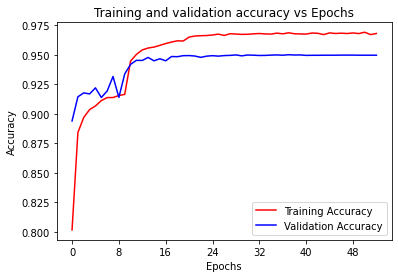

In [22]:
plt.plot(epochs, acc, 'r', label='Training Accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation Accuracy')

plt.xlabel("Epochs")
plt.xticks(x_tick)
plt.ylabel("Accuracy")
plt.title('Training and validation accuracy vs Epochs')
plt.legend()

fig_name_eps = "accuracy.eps"
fig_name_jpg = "accuracy.jpg"

plt.savefig(os.path.join(char, fig_name_eps))
plt.savefig(os.path.join(char, fig_name_jpg))

plt.show()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


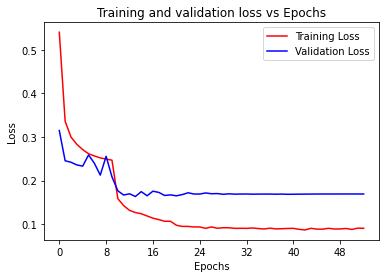

In [23]:
plt.plot(epochs, loss, 'r', label="Training Loss")
plt.plot(epochs, val_loss, 'b', label="Validation Loss")

plt.xlabel("Epochs")
plt.xticks(x_tick)
plt.ylabel("Loss")
plt.title('Training and validation loss vs Epochs')
plt.legend()

fig_name_eps = "loss.eps"
fig_name_jpg = "loss.jpg"

plt.savefig(os.path.join(char, fig_name_eps))
plt.savefig(os.path.join(char, fig_name_jpg))

plt.show()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


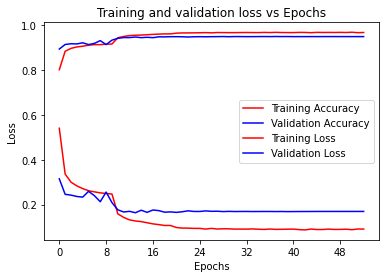

In [24]:
plt.plot(epochs, acc, 'r', label='Training Accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation Accuracy')
plt.plot(epochs, loss, 'r', label="Training Loss")
plt.plot(epochs, val_loss, 'b', label="Validation Loss")

plt.xlabel("Epochs")
plt.xticks(x_tick)
plt.ylabel("Loss")
plt.title('Training and validation loss vs Epochs')
plt.legend()

fig_name_eps = "char.eps"
fig_name_jpg = "char.jpg"

plt.savefig(os.path.join(char, fig_name_eps))
plt.savefig(os.path.join(char, fig_name_jpg))

# Classification metrices

In [25]:
training_accuracy = train_score[1]*100
validation_accuracy = val_score[1]*100
test_accuracy = test_score[1]*100

print("The training accuracy is: " + str(training_accuracy) + ' %')
print("The validation accuracy is: " + str(validation_accuracy) + ' %')
print("The test accuracy is: " + str(test_accuracy) + ' %')

The training accuracy is: 98.3863353729248 %
The validation accuracy is: 94.95499730110168 %
The test accuracy is: 94.85235810279846 %


In [26]:
test_accuracy = test_score[1]*100
test_precision = test_score[2]*100
test_recall = test_score[3]*100
tp = int(test_score[4])
tn = int(test_score[5])
fp = int(test_score[6])
fn = int(test_score[7])

f1 = 2*((test_precision*test_recall)/(test_precision+test_recall))
sensitivity = (tp/(tp+fn))*100
specificity = (tn/(tn+fp))*100

In [27]:
print("Test Accuracy: {}".format(test_accuracy))
print("Test Precision: {}".format(test_precision))
print("Test Recall: {}".format(test_recall))
print("True Positive: {}".format(tp))
print("Test Negetive: {}".format(tn))
print("False Positive: {}".format(fp))
print("False Negetive: {}".format(fn))
print("Sensitivity: {}".format(sensitivity))
print("Specificity: {}".format(specificity))

Test Accuracy: 94.85235810279846
Test Precision: 95.00514268875122
Test Recall: 94.75761651992798
True Positive: 12002
Test Negetive: 37367
False Positive: 631
False Negetive: 664
Sensitivity: 94.75761882204327
Specificity: 98.33938628348861


# Classification result

In [28]:
def pred(test_directory, test_generator, class_no, best_model_address, dim):
    test_class_list = []
    for test_name in os.listdir(test_directory):
        test = os.path.join(test_directory, test_name)
        test_class_list.append(test)
    test_class_list.sort()
    
    y_true = test_generator.classes
    labels = test_generator.class_indices
    
    y_pred = []
    tot = len(os.listdir(test_class_list[1]))*class_no

    best_model = load_model(best_model_address)
    
    with tqdm(total=tot) as pbar:
        for i in range(class_no):
            for filename in os.listdir(test_class_list[i]):
                file = os.path.join(test_class_list[i], filename)
                img = cv2.imread(file)
                res = cv2.resize(img, (dim[0], dim[1]))
                normed = res / 255.0
                im_arr = normed.reshape(1, dim[0], dim[1], dim[2])

                pred = best_model.predict(im_arr)
                pred_categorical = keras.utils.to_categorical(pred)

                if class_no >= 2:
                    max_pred = np.argmax(pred)
                else:
                    max_pred = np.argmax(pred_categorical)

                y_pred.append(max_pred)

                pbar.set_description("Progress")
                pbar.update()
                
    return y_true, y_pred, labels

In [29]:
def report(y_true, y_pred, labels):
    from sklearn.metrics import classification_report
    from sklearn.metrics import confusion_matrix 
    
    print("Calculating CLASSIFICATION REPORT: ")
    classification_reports = classification_report(y_true, y_pred, target_names=labels)
    print(classification_reports)

    print("\nCalculating SENSITIVITY & SPECIFICITY..........:")
    cm = confusion_matrix(y_true, y_pred)
    total = sum(sum(cm))
    sensitivity = cm[0, 0] / (cm[0, 0] + cm[0, 1])
    specificity = cm[1, 1] / (cm[1, 0] + cm[1, 1])

    print("sensitivity = {:.4f}".format(sensitivity))
    print("specificity = {:.4f}".format(specificity))
    
    return cm, classification_reports, sensitivity, specificity

In [30]:
y_true, y_pred, labels = pred(test_directory, test_generator, class_no, best_model_address, dim)

Progress: : 12666it [08:57, 23.55it/s]                                          


In [31]:
cm, classification_reports, sensitivity, specificity = report(y_true, y_pred, labels)

Calculating CLASSIFICATION REPORT: 
              precision    recall  f1-score   support

         CNV       0.97      0.97      0.97      5617
         DME       0.94      0.91      0.93      1738
      DRUSEN       0.88      0.82      0.85      1328
      NORMAL       0.94      0.98      0.96      3983

    accuracy                           0.95     12666
   macro avg       0.93      0.92      0.93     12666
weighted avg       0.95      0.95      0.95     12666


Calculating SENSITIVITY & SPECIFICITY..........:
sensitivity = 0.9907
specificity = 0.9753


# Confusion Matrix

In [32]:
def conf_mat(cm, labels, char):
    fig, ax = plot_confusion_matrix(conf_mat=cm,
                                colorbar=True,
                                show_absolute=True,
                                class_names=labels,
                                show_normed=True)

    plt.savefig(os.path.join(char, 'confusion-matrix.eps'))
    plt.savefig(os.path.join(char, 'confusion-matrix.jpg'))

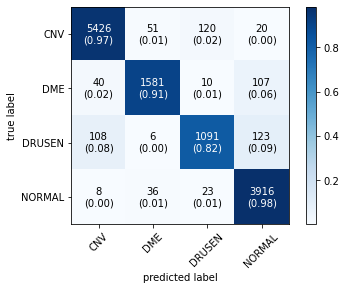

In [33]:
conf_mat(cm, labels, char)

# README

In [34]:
from contextlib import redirect_stdout

readme_name_text = "readme.txt"
print(f"Please read the text file named {readme_name_text} for detailed information of the model.")

completeName_txt = os.path.join(char, readme_name_text) 

readme = open(completeName_txt, "w")

if len(os.listdir(train_directory)) > 2:
    readme.write(f"This is a {len(os.listdir(train_directory))}-class CLASSIFICATION")
else:
    readme.write("This is a BINARY CLASSIFICATION")


readme.write("\n\n--HYPERPARAMETERS--\n")
readme.write(f"\nInitial Learning Rate = {learning_rate}")
readme.write(f"\nNo. of epochs = {len(acc)}")
readme.write(f"\nBatch Size = {batch_size}")


readme.write("\n\n--MODEL-PARAMETERS--")
# readme.write(f"\nDropout for feature extraction = {(int(f_dropout*100))} %")
# readme.write(f"\nDropout for dense layer = {(int(d_dropout*100))} %")
readme.write(f"\nOptimizer = {optimizer}\n\n")


readme.write("Trained on a Custom Prebuilt Model\n")
# readme.write(f"\nFilter size = {size_filter}x{size_filter}\n\n")
with redirect_stdout(readme):
    model.summary()
        
    
readme.write("\n\n--MODEL-PERFORMANCE--")
readme.write(f"\nTest Accuracy = {test_accuracy} %")
readme.write(f"\nTest Precision = {test_precision} %")
readme.write(f"\nTest Recall = {test_recall} %")
readme.write(f"\nTrue Positive = {tp}")
readme.write(f"\nTrue Negetive = {tn}")
readme.write(f"\nFalse Positive = {fp}")
readme.write(f"\nFalse Negetive = {fn}")
readme.write(f"\nSensitivity = {sensitivity}")
readme.write(f"\nSpecificity = {specificity}\n\n\n")


readme.write("\n\n--MODEL-CHARACTERISTICS--")
readme.write(f"\nacc = {acc}")
readme.write(f"\n\nval_acc = {val_acc}")
readme.write(f"\n\nloss = {loss}")
readme.write(f"\n\nval_loss = {val_loss}")


readme.write("\n\n--Classification Report--\n")
readme.write(classification_reports)

readme.write(f"\nSensitivity = {sensitivity*100} %")
readme.write(f"\nSpecificity = {specificity*100} %")


readme.write(f"\nExecution Time: {duration} seconds")

readme.write("\n\nCreated using Self-Regulated Image Classifier using Convolution Neural Network")

readme.close()

Please read the text file named readme.txt for detailed information of the model.
